# Pet breed classification

This is an experiment building an image classifier using transfer learning, with a
forward-forward network for the classifier head. Using Mobilnet_v2 to do feature 
extraction from lareger/color images, and then feed the resulting latent images through
the FF network.

In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from layers import FFDense
from img_classifier import ImageClassifier
import utils


c:\Users\karen\myprojects\forward-forward\fwd-fwd\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download the pretrained CNN 

In [8]:
mobilenet_v2 = "https://tfhub.dev/google/imagenet/mobilenet_v2_050_224/feature_vector/5"
feature_extractor_model = mobilenet_v2

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    output_shape=[1280],
    trainable=False)
     
extractor = Sequential([feature_extractor_layer])

## Collect data

In [9]:
(raw_train, raw_test), metadata = tfds.load('OxfordIIITPet',
                                            split=['train', 'test'],
                                            with_info=True,
                                            as_supervised=True)

def format_image(image, label):
  image = tf.image.resize(image, (224, 224)) / 255.0
  return image, label

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
class_names = metadata.features['label'].names

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE)
test_batches = raw_test.map(format_image).batch(BATCH_SIZE)

Look at a sample of the images

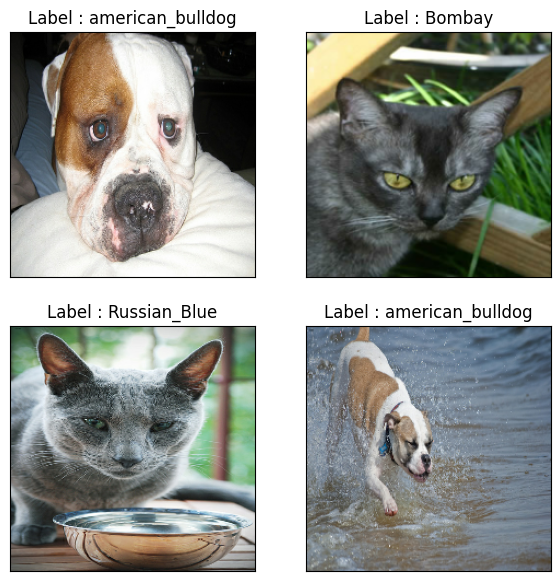

In [10]:
ds = raw_train.take(100)
imgs = []
labels = []
for image, label in tfds.as_numpy(ds):
  image = tf.image.resize(image, (224, 224)) / 255.0
  imgs.append(image)
  labels.append(label)
imgs = np.array(imgs)
labels = np.array(labels)

utils.show_samples(imgs, labels, class_names)

## Back propagation model with transfer learning

For comparison

In [11]:
clf_base = Sequential([extractor,
                       Dense(num_classes, activation='softmax')])

clf_base.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy')
hist = clf_base.fit(train_batches, epochs=10, verbose=1)

Epoch 1/10
115/115 [==============================] - 40s 316ms/step - loss: 0.9960
Epoch 2/10
115/115 [==============================] - 37s 317ms/step - loss: 0.2991
Epoch 3/10
115/115 [==============================] - 38s 323ms/step - loss: 0.1627
Epoch 4/10
115/115 [==============================] - 40s 337ms/step - loss: 0.0925
Epoch 5/10
115/115 [==============================] - 38s 322ms/step - loss: 0.0621
Epoch 6/10
115/115 [==============================] - 39s 334ms/step - loss: 0.0262
Epoch 7/10
115/115 [==============================] - 40s 336ms/step - loss: 0.0194
Epoch 8/10
115/115 [==============================] - 37s 316ms/step - loss: 0.0148
Epoch 9/10
115/115 [==============================] - 37s 313ms/step - loss: 0.0063
Epoch 10/10
115/115 [==============================] - 37s 313ms/step - loss: 0.0013


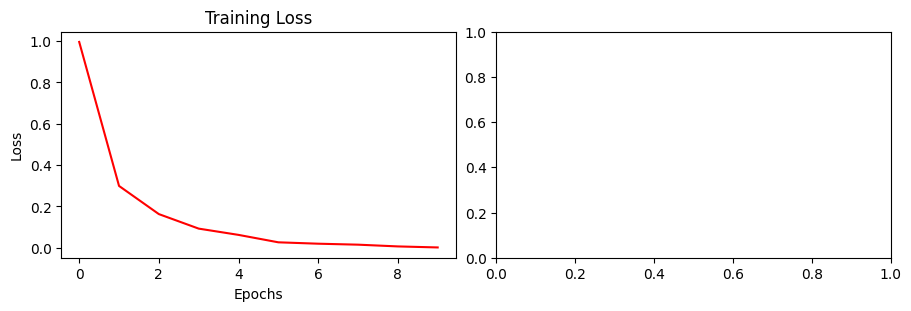

115/115 [==============================] - 37s 318ms/step
Backprop Accuracy = 84.46%


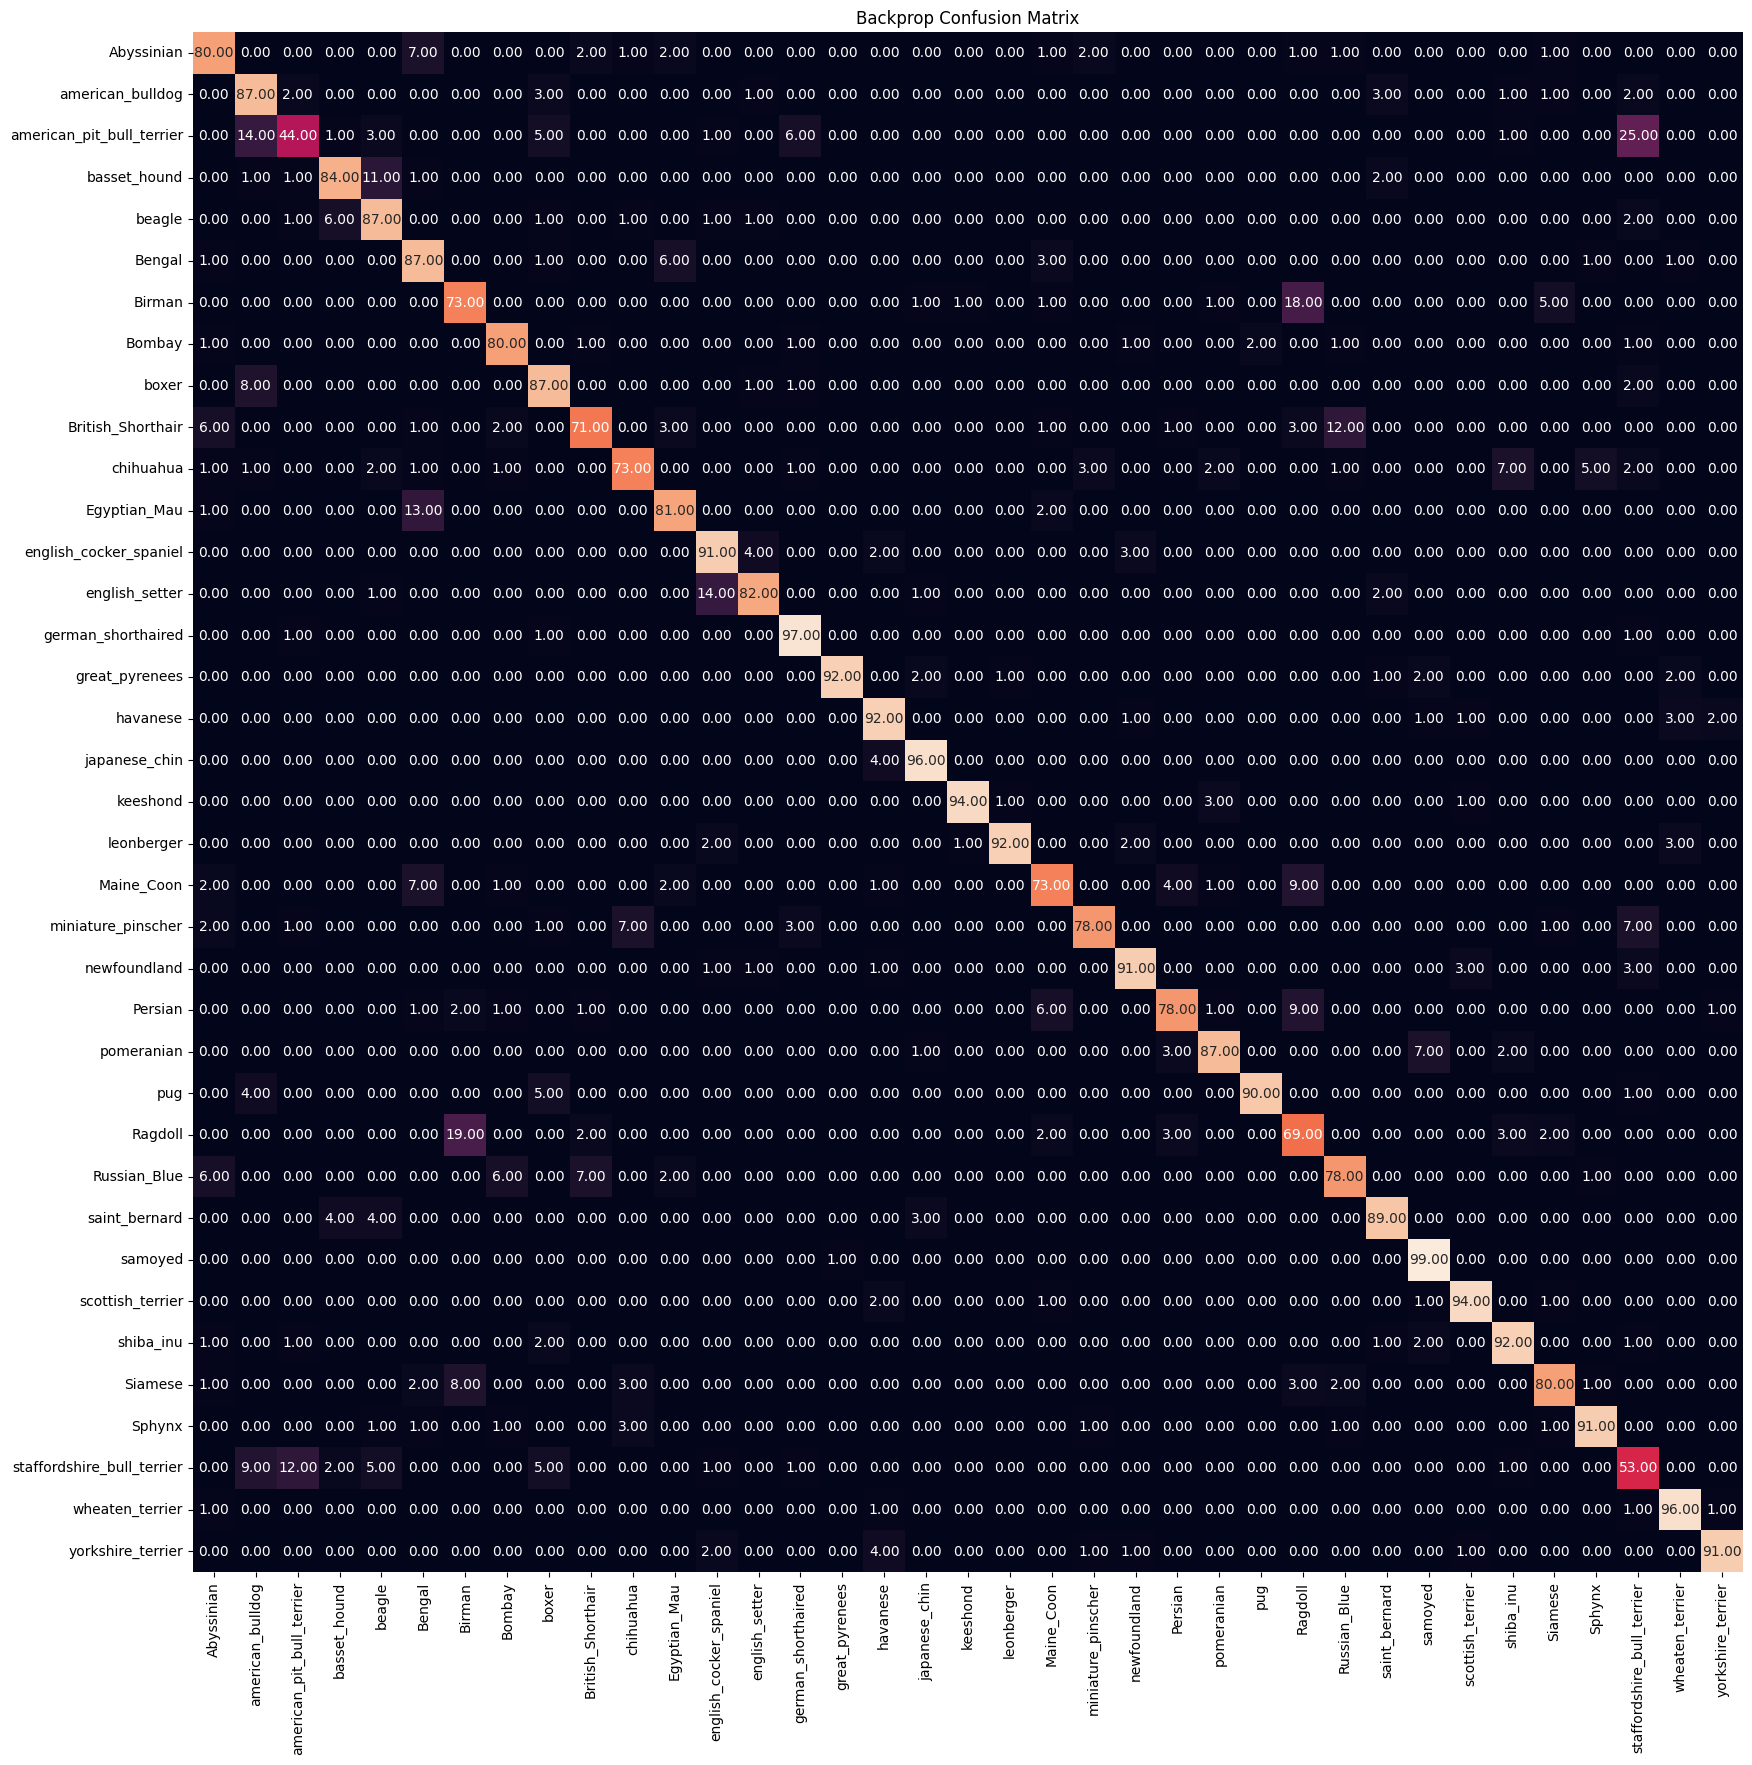

In [16]:
utils.plot_history(hist.history)

pred_labels = clf_base.predict(test_batches, verbose=1)
pred_labels = np.argmax(pred_labels, axis=1)

y = [labels.numpy() for _, labels in test_batches]
y = np.concatenate(y)

utils.evaluate(y, pred_labels, class_names, desc='Backprop', figsize=20)

## Train our classifier with Forward-Forward top

10 epochs as in the base case

In [17]:
clf = ImageClassifier(extractor, [num_classes], len(class_names), learning_rate=0.01, iterations=1)
hist = clf.fit(train_batches, epochs=10)

Epoch 1
115/115[====================] 46.1475 sec - loss: 0.7349
Epoch 2
115/115[====================] 45.2015 sec - loss: 0.6995
Epoch 3
115/115[====================] 45.1916 sec - loss: 0.6838
Epoch 4
115/115[====================] 45.2118 sec - loss: 0.6679
Epoch 5
115/115[====================] 44.6538 sec - loss: 0.6537
Epoch 6
115/115[====================] 46.5759 sec - loss: 0.6407
Epoch 7
115/115[====================] 51.9412 sec - loss: 0.6292
Epoch 8
115/115[====================] 48.9025 sec - loss: 0.6187
Epoch 9
115/115[====================] 47.9312 sec - loss: 0.6087
Epoch 10
115/115[====================] 46.9963 sec - loss: 0.5996


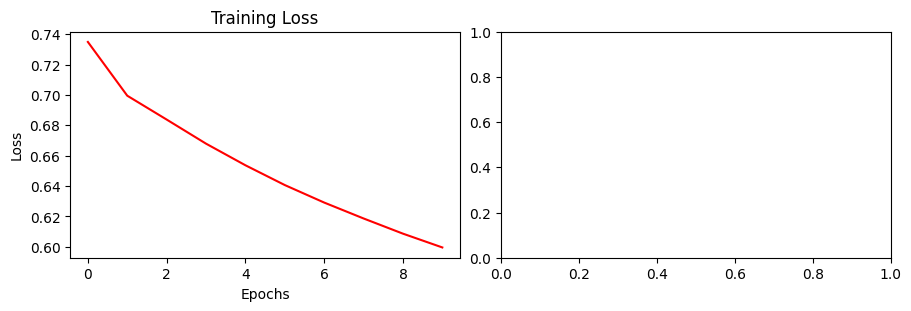

115/115[====================] 4 min 6.76 sec
FF Accuracy = 58.90%


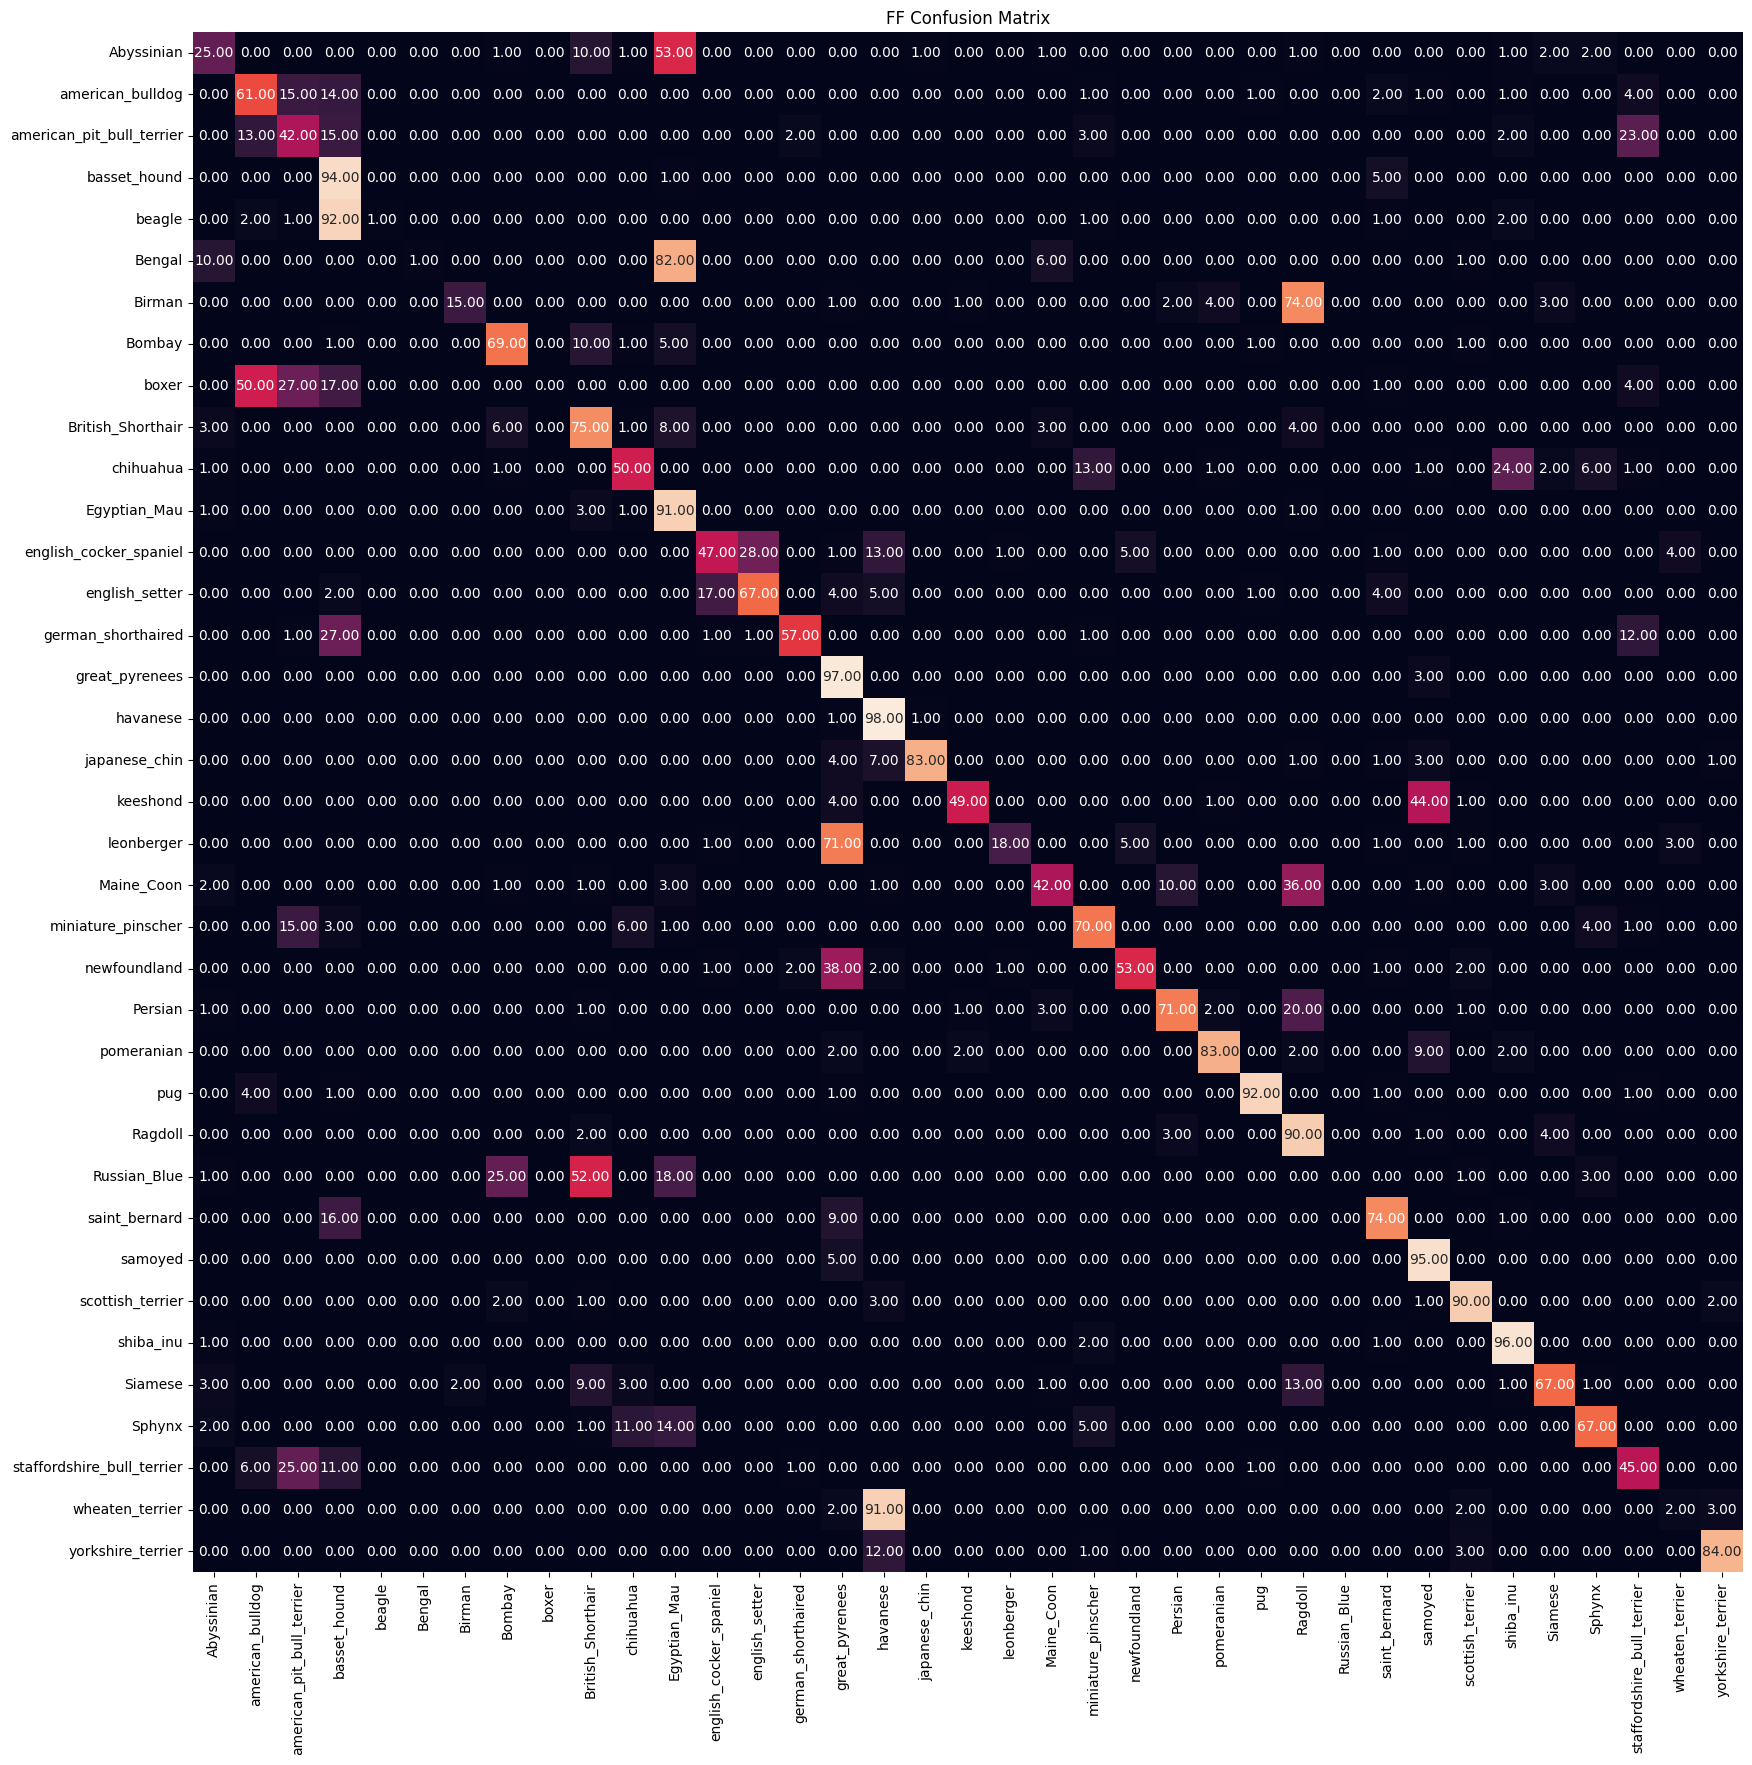

In [19]:
utils.plot_history(hist)

y = [labels.numpy() for _, labels in test_batches]
y = np.concatenate(y)

pred_labels = clf.predict(test_batches)
utils.evaluate(y, pred_labels, class_names, desc='FF', figsize=20)


## Forward-Forward larger classifier head, 100 epochs

In [20]:
clf = ImageClassifier(extractor, [num_classes], len(class_names), learning_rate=0.01, iterations=1)
hist = clf.fit(train_batches, epochs=100)

Epoch 1
115/115[====================] 47.7194 sec - loss: 0.7365
Epoch 2
115/115[====================] 48.8573 sec - loss: 0.7013
Epoch 3
115/115[====================] 48.8627 sec - loss: 0.6873
Epoch 4
115/115[====================] 48.6075 sec - loss: 0.6722
Epoch 5
115/115[====================] 49.2483 sec - loss: 0.6573
Epoch 6
115/115[====================] 50.5233 sec - loss: 0.6442
Epoch 7
115/115[====================] 49.8699 sec - loss: 0.6325
Epoch 8
115/115[====================] 48.4970 sec - loss: 0.6214
Epoch 9
115/115[====================] 48.8570 sec - loss: 0.6109
Epoch 10
115/115[====================] 49.0715 sec - loss: 0.6012
Epoch 11
115/115[====================] 49.7612 sec - loss: 0.5925
Epoch 12
115/115[====================] 50.7618 sec - loss: 0.5844
Epoch 13
115/115[====================] 51.0713 sec - loss: 0.5767
Epoch 14
115/115[====================] 52.3665 sec - loss: 0.5696
Epoch 15
115/115[====================] 52.9709 sec - loss: 0.5632
Epoch 16
115/115[==

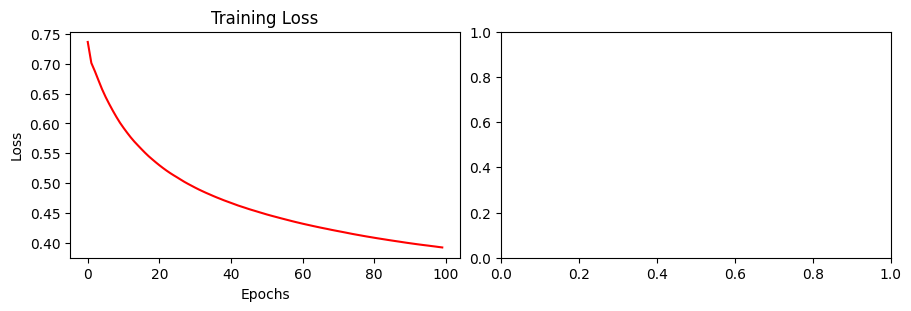

115/115[====================] 5 min 43.48 sec
FF Accuracy = 79.69%


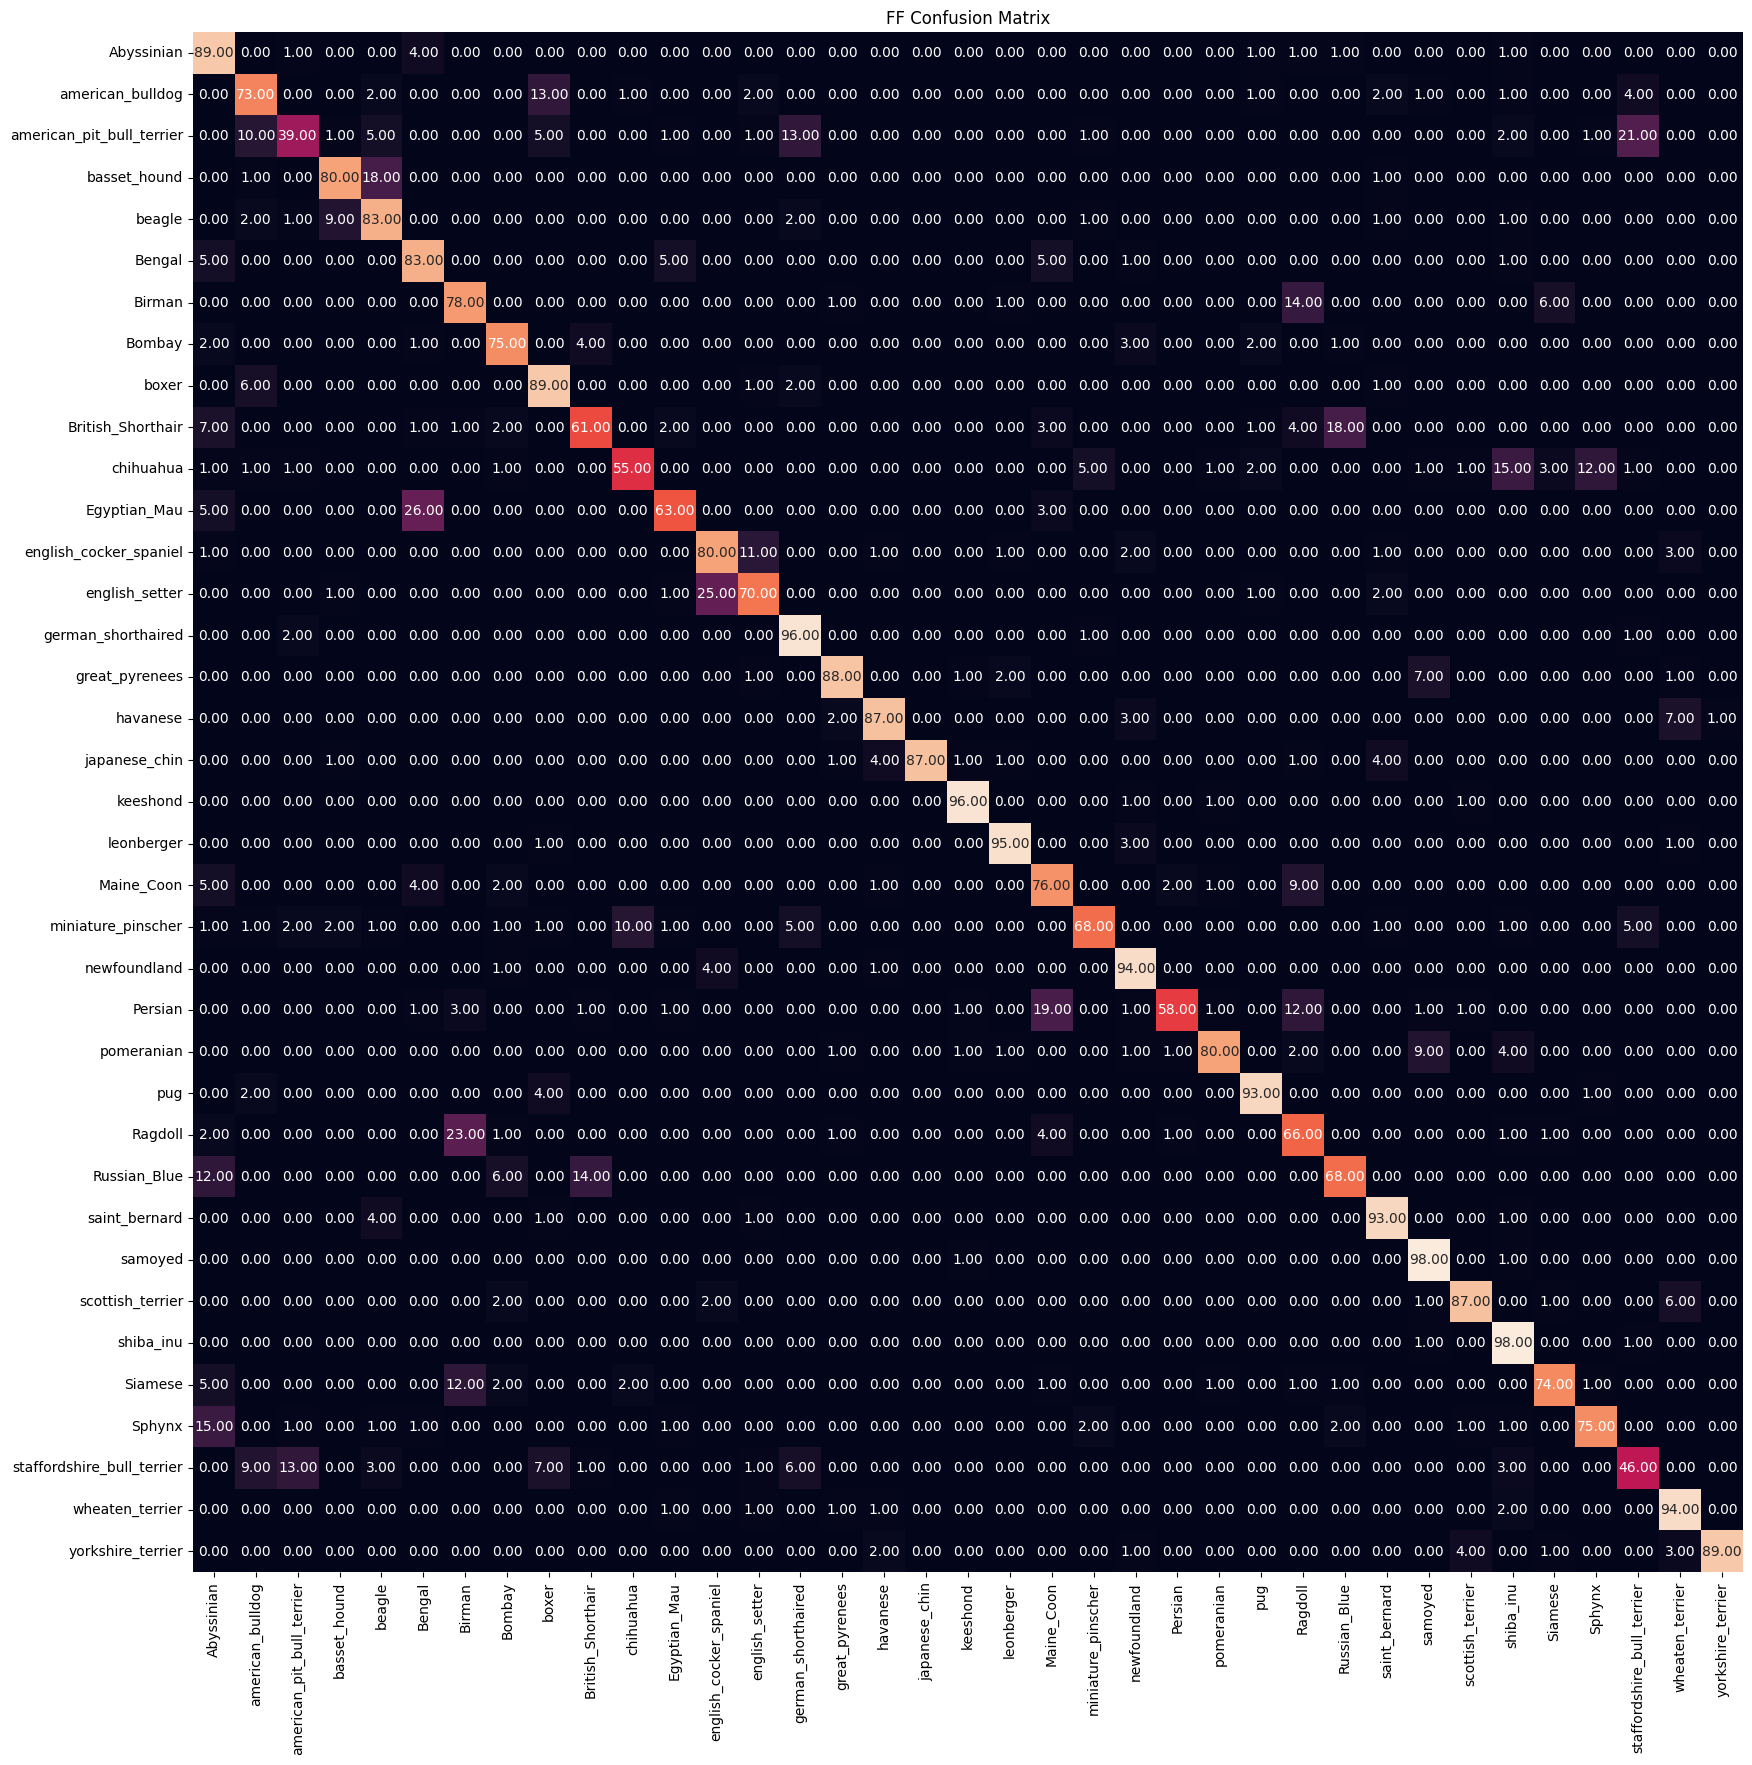

In [23]:
utils.plot_history(hist)

y = [labels.numpy() for _, labels in test_batches]
y = np.concatenate(y)

pred_labels = clf.predict(test_batches)
utils.evaluate(y, pred_labels, class_names, desc='FF', figsize=20)